In [1]:
import torch

In [2]:
x = torch.tensor([[1.0, 2.0], [3.0, 4.0]])
print(x.shape)

x = torch.tensor(2.0, requires_grad=True)  #tracks what happens to it 
y = x **2   #will be noted in graph
y.backward()  #walks back thorugh graph and calculates gradents for every tensor that has requires_grad=True
print(x.grad)

#note that the gradient is 2x, therefore at x = 2, the gradient is 4

torch.Size([2, 2])
tensor(4.)


loss is the output of a bunch of operations (forward pass)
call backward() on the loss
graph is used to see how each param should be tweaked
optimizer takes those gradients and updates the params accordingly



In [3]:
import torch.nn as nn
#contains nn.Linear, nn.Conv2d etc
  
class MyModel(nn.Module):   #inherets from nn.Module
    def __init__(self):   #this is the class constructor, it runs when you say model = MyModel()
        #define what components of the model you want to use here
        super().__init__()      #calls teh parent class's constructor, nn.Module, to initialize the model
        self.fc = nn.Linear(10,1)  # this creates a fully connected linear layer that takes in 10 features and outputs 1 value
        #it gets stured as self.fc, so you can access it later in the class


#then define how the input moves through the model
    def forward(self,x):
        return self.fc(x)  #input x gets passed through the linear layer
    
#input tensor -> linear layer -> output tensor


x = torch.tensor([[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]])
model = MyModel()
output = model(x)
print(output)

tensor([[3.7847]], grad_fn=<AddmmBackward0>)


<function matplotlib.pyplot.show(close=None, block=None)>

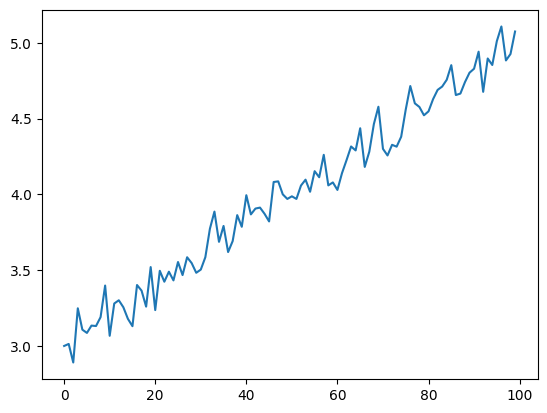

In [4]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

x = torch.linspace(0, 1, 100).unsqueeze(1) #unsqueeze makes it a vector

y = 2*x + 3 + 0.1 * torch.randn(x.size())  #y = 2x + 3 + noise
plt.plot(y)
plt.show

In [5]:
#define the model using a class
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1,1) #in dim 10, out dim 1

    def forward(self, x):
        return self.linear(x)
    
model = LinearRegressionModel()

In [6]:
#define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr = 0.1) # stochastic gradient descent, lr = learning rate

In [7]:
#training loop
epochs = 100
for epoch in range(epochs):
    #forward pass
    y_pred = model(x)
    loss = criterion(y_pred, y)

    #backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # report progress
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 0.1139
Epoch [20/100], Loss: 0.0479
Epoch [30/100], Loss: 0.0386
Epoch [40/100], Loss: 0.0317
Epoch [50/100], Loss: 0.0264
Epoch [60/100], Loss: 0.0223
Epoch [70/100], Loss: 0.0192
Epoch [80/100], Loss: 0.0169
Epoch [90/100], Loss: 0.0151
Epoch [100/100], Loss: 0.0137


some words
consider model = MyModel()
- this creates an instance of the class MyModel, and binds it to the name model
model is the self
python has calles __init__, which contains self.linear
so now model.linear is an actual thing, its an instance of a nn.Linear layer
--this object has weights, a bias, and a __call__() method itself (this is recursive)

nn.Module has a __call__() method, this means that when you run model(x) it really runs model.__call__(x)
okay
this does many things before it touches the forward() method. 
- it checks youre in training or eval mode
- does hooks stuff (dw)
- calls forward() function wiht the input
-- __call__() is programmed to look for and run forward()!!, it will call self.forward(...)

nn.Module will have 
def __ca;__(self, *input, **kwargs):
    return self.forward(*input, **kwargs)

so it actually returns self.forward(x)
returns self.linear(x), a linear transform 
e.g. we have made an instance of the class, which is initiallied with a nn.Linear object
this is itself a class, that we instantiate - it is a learnable function that performs a linear transformation
it performs y = xW^t + b
W shape (out_features, in_features)
bias shape (out_features, in_features)

what happens then when you do linear(x)?
you call __call__() method of nn.Module, which runs
def forward(self, iput):
    return F.liinear(input, self.weight, self.bias)
its a callable object that wraps 
y = input @ weight.T + bias 
except the weights and biases are learnable, tracked by gradients, and registered for saving/loading

---------------------
loss.backward()
this caluclates the gradient of the loss wrt each parameter. 
PyTorch Accumulates gradients by default, so .backwards() adds to these
so zero_grad() is used to stop gradients from piling up every epoch, assuming you dont want to accumulate them. it sets .grad attributes to None. gradients are therefore calculated next from the current loss, not mixing with last update. 

so what is loss?
loss is a number, that tells you how wrong the model predictions are, and compates to target values. 
lower = closer to good
y_pred is guess, y_true is ground truth
loss function is something like nn.MSELoss() or nn.CrossEntropyLoss()
MSE is mean square error. loss = (ypred - ytrue)**2
cross entropy is for classification tasks, measuring how well predicted prob match actual class labels. 

what does optimizer.step() then do 
it reads the .grad values and nudges the parrameters based on them. so .backwards() computes how wrong we are, and how much each parameter contributes to that wrongness, and .step() updates the params to make us less wrong next time. 

what is the parameter Landscape?
- consider that loss = (w-2)^2
w is the model parameter (?)
loss function is a parabola with min at w = 2

if at w = 5, slow is +6 therefore go left, at 2 = 0 slope is -4, go right. 
so you update w = w - learning_rate * grad
e.g w = 5 - 0.1 * 6 = 4.4 
you have stepped downhill


each axis of the param space is a model parameter: weight1, w2, w3 ... b1, b2, b3...
the height is the loss value!!!
to be at a min is for there to be little change in predicted value and true value. 


how are the gradients calculated so that we know were going downhill??
- we dont do numerical differentiation - we use Autograd. 

you run loss.backward(), and it walks back through the computational graph, and uses actual algebra to calculate gradients 

example:
w = torch.tensor(2.0, requires_grad = True)
x = torch.tensor(3.0)
y_true = torch.tensor(15.0)

y_pred = w*x
loss = (y_pred - y_true)**2

PyTorch builds a graph, ypred = w * x
loss = MSE
graph:
    w     x
     \   /
      *         ← node: multiplication (y_pred)
       \
      (-15)     ← node: subtraction (y_pred - y_true)
         \
         **2    ← node: square (loss)

each operation is a nodw in the graph
backwards then goes back thorugh that graph, from loss to w, and applies the chain rule along the way

dloss/doutput * doutput/dw_i

e.g. z = w*x
loss = (z-y)**2

final output is loss
intermediate is z
want dloss / dw
so we find dloss / dz * dz/dw

e.g. 2(z-y) * x

hence:
dloss/dw = d((wx - y)^2) /dw
         = 2(wx - y) * x
and stores w.grad 

what if we have several laters?
outupt = layer2(laer1(x))
loss = loss_fn(output, y)

x -> layer1 -> layer2 -> loss_fn -> loss

so we go back through the graph:
we calculate dloss / dweight 2
and dloss / dweight1

e.g. by dl/dz2 * dz2/dw2
or dl/dz2 * dz2/dz1 * dz1 / dw1

and we sub in the weights for this step on those layers, and store these to weights.grad 
when we we .backward() we perform w_i = w-I - learning_rate * grad_i
moving againt the increasing slope


------------------
activatin functions:
how much each neuron actually participates in learning during backprop
these provide us with non-linearity, power to approximate ocmples functions = learning things that aren't lines

-ReLU(x) = max(0, x)

               /
              /
             /               
            /         
___________/

e.g. if x is positive, it passes through unchanged, if its negative it gets set to 0. 
the gradient d/dx ReLU(x) = 0 if x>0, otherwise 0. 

consider what a 0 gradient means : it means that the weight will not be updated! this is known as dying ReLU problem - a neuron can go silent and never recover. when its active, the gradient passes through cleanly. 


-sigmoid:
1/1*e^-x

squishes inputs into S-curve, range (0, 1)
its gradient is 0 for large and small weights - updates slow down, but large for weights near 0, can contribute to vanishing gradients over many layers

-tanh
sigmoid moved down, centered at 0. largest derivative at 0 and a 0 centered output - still saturates at high / low x. 


so what does it do?
- it essentially installs gates between layers - there are fancier actiavtions for deep networks, or leaky ReLU's that fix the dead neuron issue given small negative gradients. Activation happens therefore betwen the layers. 





Learned weights: 1.7585, Learned bias: 3.1283


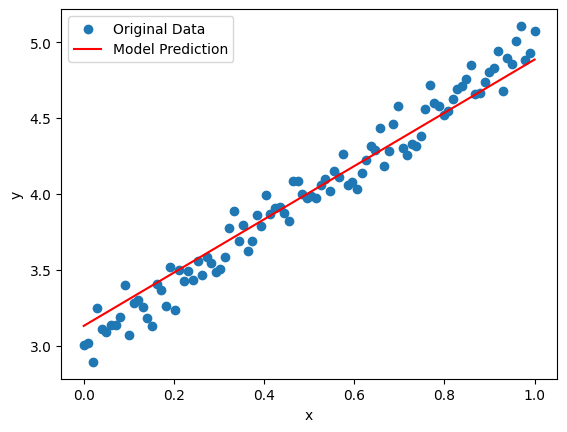

In [8]:
learned_weights = model.linear.weight.item()
learned_bias = model.linear.bias.item()
print(f'Learned weights: {learned_weights:.4f}, Learned bias: {learned_bias:.4f}')

plt.scatter(x.detach().numpy(), y.detach().numpy(), label='Original Data')
plt.plot(x.detach().numpy(), y_pred.detach().numpy(), color='red', label='Model Prediction')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

#detach removes the tensor from the graph, so it doesn't track gradients anymore
#this is useful when you want to visualize the data without tracking gradients

Epoch 0, Loss: 0.2825
Epoch 5, Loss: 0.1681
Epoch 10, Loss: 0.1005
Epoch 15, Loss: 0.0599
Epoch 20, Loss: 0.0355
Epoch 25, Loss: 0.0209
Epoch 30, Loss: 0.0122
Epoch 35, Loss: 0.0071
Epoch 40, Loss: 0.0041
Epoch 45, Loss: 0.0023
Epoch 50, Loss: 0.0013
Epoch 55, Loss: 0.0008
Epoch 60, Loss: 0.0004
Epoch 65, Loss: 0.0002
Epoch 70, Loss: 0.0001
Epoch 75, Loss: 0.0001
Epoch 80, Loss: 0.0000
Epoch 85, Loss: 0.0000
Epoch 90, Loss: 0.0000
Epoch 95, Loss: 0.0000
gradients after backprop:
0.weight.grad = tensor([[-0.0005, -0.0009],
        [-0.0005, -0.0010]])
0.bias.grad = tensor([-0.0005, -0.0005])
2.weight.grad = tensor([[0.0042, 0.0035],
        [0.0030, 0.0025]])
2.bias.grad = tensor([0.0026, 0.0019])


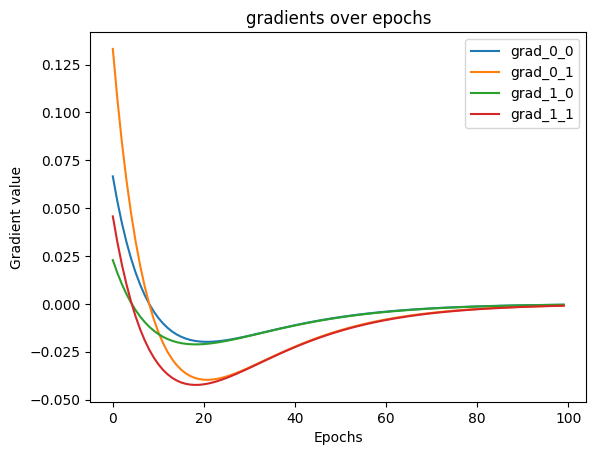

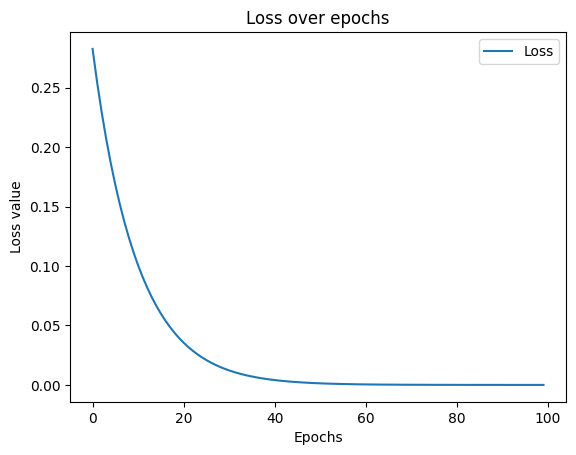

In [43]:
torch.manual_seed(42)
#manual_seed sets the random seed for generating random numbers, ensuring reproducibility

#input and target
x = torch.tensor([[1.0, 2.0]], requires_grad = False)
y_true = torch.tensor([[0.0, 0.0]]) #these are the target values we want to predict


#defininf a model
model_1 = nn.Sequential(
    nn.Linear(2, 2), 
    nn.ReLU(), 
    nn.Linear(2, 2)

)

criterion = nn.MSELoss()
optimizer = optim.SGD(model_1.parameters(), lr = 0.01)

grad_history = []
loss_history = []
epochs = 100
for epoch in range(epochs):

    y_pred = model_1(x)
    loss = criterion(y_pred, y_true)  #calculates the loss between the predicted and true values

    #want to zero the frads, .backwards, then step
    optimizer.zero_grad()
    loss.backward()
    loss_history.append(loss.item())
    grad_history.append(model_1[0].weight.grad.clone())
    optimizer.step()

    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

y_pred = model_1(x)

print('gradients after backprop:')
for name, param in model_1.named_parameters():
    print(f'{name}.grad = {param.grad}')

for i in range(2):
    for j in range(2):
        plt.plot([g[i][j].item() for g in grad_history], label=f'grad_{i}_{j}')

#clever syntax here, g in set of tensors is itself a tensor on which we can ask for the i,jth element and call the item()


plt.legend()
plt.title("gradients over epochs")
plt.xlabel("Epochs")
plt.ylabel("Gradient value")    
plt.show()

plt.plot(loss_history, label='Loss')
plt.title("Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss value")
plt.legend()
plt.show()


Mean Squared Error: 178.8464
R^2 Score: 0.9811


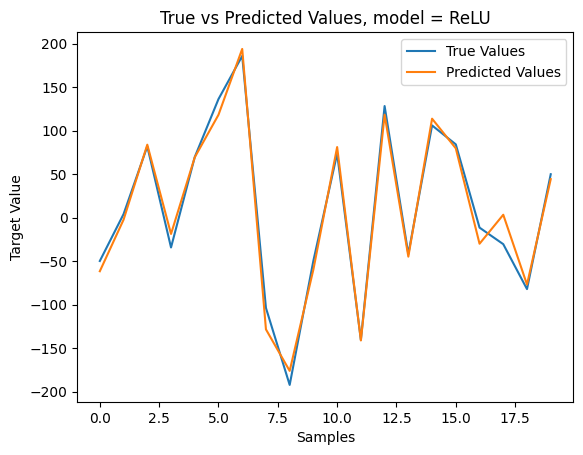

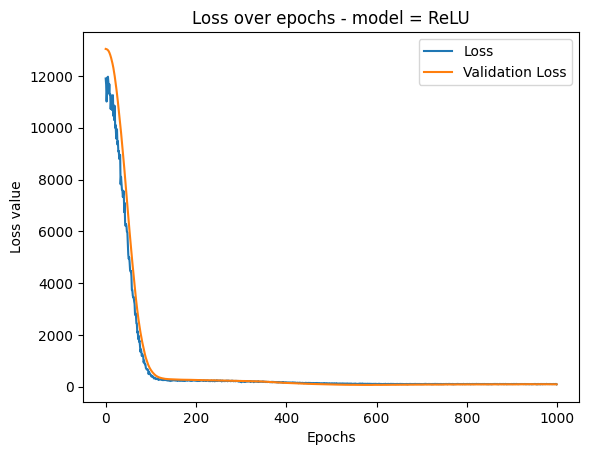

Mean Squared Error: 169.1162
R^2 Score: 0.9821


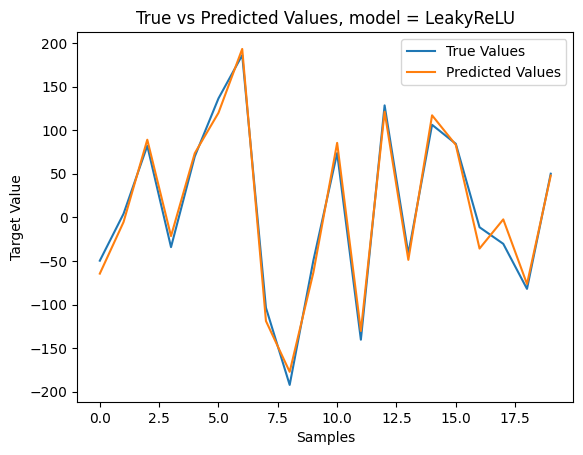

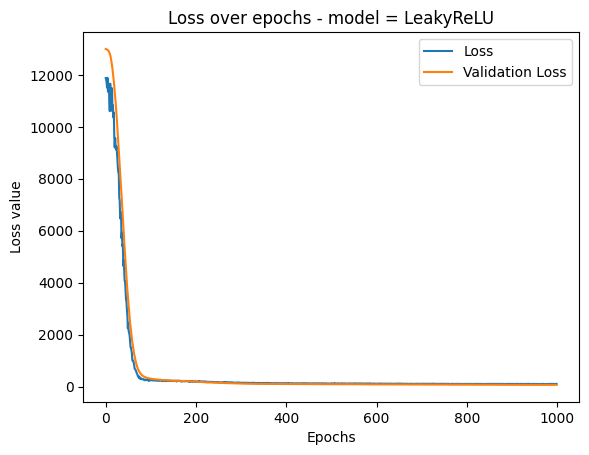

Mean Squared Error: 270.4486
R^2 Score: 0.9714


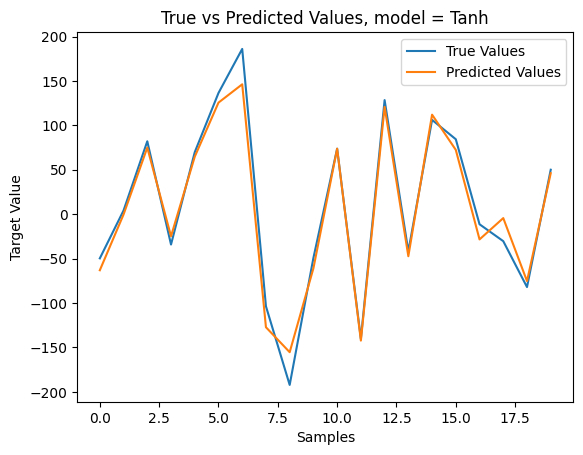

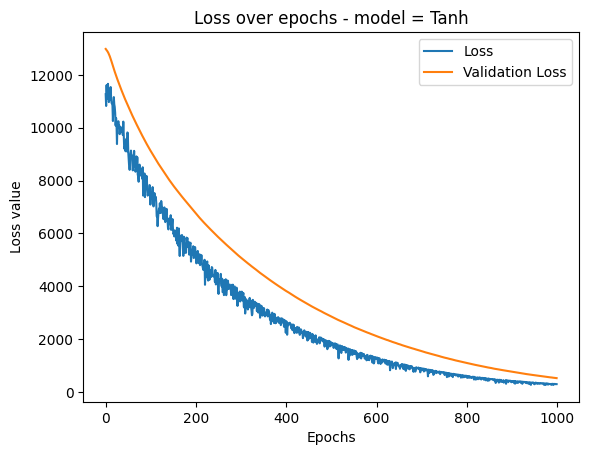

(RegressionModel(
   (layer1): Linear(in_features=2, out_features=4, bias=True)
   (activation): Tanh()
   (layer2): Linear(in_features=4, out_features=1, bias=True)
 ),
 [11266.286295572916,
  10820.840006510416,
  11609.934488932291,
  11091.599283854166,
  11345.899983723959,
  11658.525797526041,
  11271.266438802084,
  10967.001302083334,
  11194.198486328125,
  11035.271647135416,
  11089.16650390625,
  11536.165364583334,
  11125.07470703125,
  10935.0830078125,
  10902.1484375,
  10840.718994140625,
  10251.043701171875,
  10833.462972005209,
  11156.406087239584,
  10884.24462890625,
  10781.967529296875,
  10560.74560546875,
  10080.331868489584,
  10361.928955078125,
  10134.290120442709,
  9380.7333984375,
  10189.392578125,
  10010.70703125,
  10243.572998046875,
  10013.103841145834,
  10080.336547851562,
  9754.666259765625,
  9945.24658203125,
  10029.332194010416,
  9826.812093098959,
  9858.76513671875,
  9914.947916666666,
  9890.033203125,
  9720.48583984375,
  1022

In [111]:
from sklearn.datasets import make_regression

X, y = make_regression(n_samples = 100, n_features = 2, noise = 10, random_state=42) #n_samples means number of samples, n_features means number of input feasures, a feasure is a column in the dataset, e.g. hieght, weight, age etc.

#n_features meaans number of input feasures, a feasure is a column in the dataset, e.g. hieght, weight, age etc. 

#want to standardize the data, so that it has mean 0 and std 1
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X) #fit_transform fits the scaler to the data and transforms it at the same time, so that the data is standardized


#then want to split the data into traininf and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #test_size means what percentage of the data you want to use for testing, 0.2 means 20% of the data will be used for testing and 80% for training
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42) #this splits the training data into training and validation data, so that we can use the validation data to tune the hyperparameters of the model
X_train = torch.tensor(X_train, dtype=torch.float32) #convert the data to a tensor, so that it can be used in pytorch
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1) #unsqueeze adds a dimension to the tensor, so that it can be used in pytorch, y_train is a 1D tensor, but we want it to be a 2D tensor with one column and as many rows as there are samples in the dataset
X_validation = torch.tensor(X_validation, dtype=torch.float32) #convert the data to a tensor, so that it can be used in pytorch
y_validation = torch.tensor(y_validation, dtype=torch.float32).unsqueeze(1) #unsqueeze adds a dimension to the tensor, so that it can be used in pytorch, y_train is a 1D tensor, but we want it to be a 2D tensor with one column and as many rows as there are samples in the dataset
x_test = torch.tensor(X_test, dtype=torch.float32) #convert the data to a tensor, so that it can be used in pytorch
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1) #unsqueeze adds a dimension to the tensor, so that it can be used in pytorch, y_train is a 1D tensor, but we want it to be a 2D tensor with one column and as many rows as there are samples in the dataset

#batching here:
from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(
    train_dataset,
    batch_size=10,
    shuffle=True,
    drop_last=True) #batch_size means how many samples you want to use in each batch, shuffle means whether you want to shuffle the data before batching it
#now we loop over the DataLoader


#building the model 
class RegressionModel(nn.Module):
    def __init__(self, activation_fn = nn.ReLU()):
        super().__init__()
        self.layer1 = nn.Linear(2, 4)
        self.activation = activation_fn
        self.layer2 = nn.Linear(4, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.activation(x)
        x = self.layer2(x)
        return x
    
model_relu = RegressionModel(activation_fn = nn.ReLU()) 
model_leaky = RegressionModel(activation_fn = nn.LeakyReLU())
model_tanh = RegressionModel(activation_fn = nn.Tanh())


criterion = nn.MSELoss()
def train_model(model, train_loader, criterion, epochs = 1000):
    optimizer = optim.Adam(model.parameters(), lr = 0.01) 
    loss_history = []
    validation_loss_history = []
    for _ in range(epochs):
        epoch_loss = 0
        for x_batch, y_batch in train_loader:

            optimizer.zero_grad()

            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward() 
            #loss_history.append(loss.item())
            epoch_loss += loss.item()

            optimizer.step()

        loss_history.append(epoch_loss / len(train_loader))

        #want to know evaluate on the validation set
        with torch.no_grad():
            y_pred_validation = model(X_validation)
            validation_loss = criterion(y_pred_validation, y_validation)
            validation_loss_history.append(validation_loss.item())

        if validation_loss < 1:
            break


        
    #testing the model
    from sklearn.metrics import mean_squared_error, r2_score
    y_pred_trained = model(x_test).detach().numpy()  #detach removes the tensor from the graph, so it doesn't track gradients anymore

    mse = mean_squared_error(y_test, y_pred_trained)
    r2 = r2_score(y_test, y_pred_trained)

    print(f'Mean Squared Error: {mse:.4f}')
    print(f'R^2 Score: {r2:.4f}')

    plt.plot(y_test.numpy(), label='True Values')
    plt.plot(y_pred_trained, label='Predicted Values')
    plt.legend()
    plt.xlabel('Samples')
    plt.ylabel('Target Value')
    plt.title(f'True vs Predicted Values, model = {model.activation.__class__.__name__}')
    plt.show()

    plt.plot(loss_history, label='Loss')
    plt.plot(validation_loss_history, label='Validation Loss')
    plt.title(f"Loss over epochs - model = {model.activation.__class__.__name__}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss value")
    plt.legend()
    plt.show()

    return model, loss_history, validation_loss_history

train_model(model_relu, train_loader, criterion)
train_model(model_leaky, train_loader, criterion)
train_model(model_tanh, train_loader, criterion)




In [109]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

class RegressionTrainer:
    def __init__(self, model, 
                 X_train, y_train, 
                 X_val, y_val, 
                 X_test, y_test,
                 batch_size=10, 
                 lr=0.01,
                 loss_fn=nn.MSELoss(),
                 activation_name=None):
        
        self.model = model
        self.criterion = loss_fn
        self.optimizer = optim.Adam(model.parameters(), lr=lr)
        self.batch_size = batch_size
        
        # Store test and val sets
        self.X_val = X_val
        self.y_val = y_val
        self.X_test = X_test
        self.y_test = y_test
        
        # Dataloader
        train_dataset = TensorDataset(X_train, y_train)
        self.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

        self.loss_history = []
        self.val_loss_history = []

        self.activation_name = activation_name or model.activation.__class__.__name__

    def train(self, epochs=1000, early_stopping_loss=1.0, verbose=False):
        for epoch in range(epochs):
            epoch_loss = 0
            for x_batch, y_batch in self.train_loader:
                self.optimizer.zero_grad()
                y_pred = self.model(x_batch)
                loss = self.criterion(y_pred, y_batch)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()
            
            avg_epoch_loss = epoch_loss / len(self.train_loader)
            self.loss_history.append(avg_epoch_loss)

            with torch.no_grad():
                val_pred = self.model(self.X_val)
                val_loss = self.criterion(val_pred, self.y_val)
                self.val_loss_history.append(val_loss.item())

            if verbose and (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}: Train Loss={avg_epoch_loss:.4f} | Val Loss={val_loss.item():.4f}")

            if val_loss.item() < early_stopping_loss:
                if verbose:
                    print(f"Early stopping triggered at epoch {epoch+1}")
                break

    def evaluate(self):
        with torch.no_grad():
            y_pred = self.model(self.X_test).detach().numpy()
            mse = mean_squared_error(self.y_test, y_pred)
            r2 = r2_score(self.y_test, y_pred)

            print(f"Model = {self.activation_name}")
            print(f"Mean Squared Error: {mse:.4f}")
            print(f"R^2 Score: {r2:.4f}")

            plt.plot(self.y_test.numpy(), label="True Values")
            plt.plot(y_pred, label="Predicted Values")
            plt.title(f"True vs Predicted - {self.activation_name}")
            plt.xlabel("Samples")
            plt.ylabel("Target")
            plt.legend()
            plt.show()

            plt.plot(self.loss_history, label="Train Loss")
            plt.plot(self.val_loss_history, label="Val Loss")
            plt.title(f"Loss over Epochs - {self.activation_name}")
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.legend()
            plt.show()

        return mse, r2


Model = ReLU
Mean Squared Error: 2267.4268
R^2 Score: 0.7599


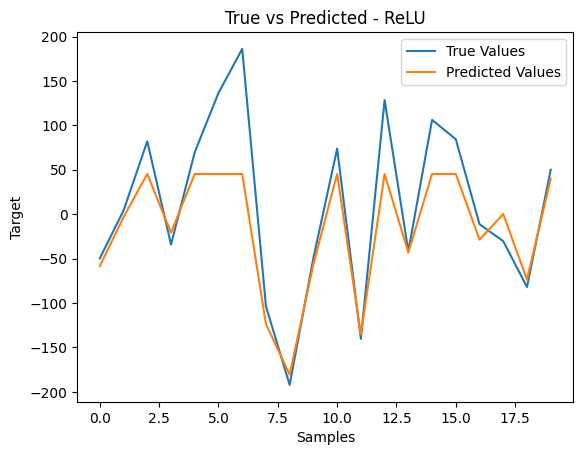

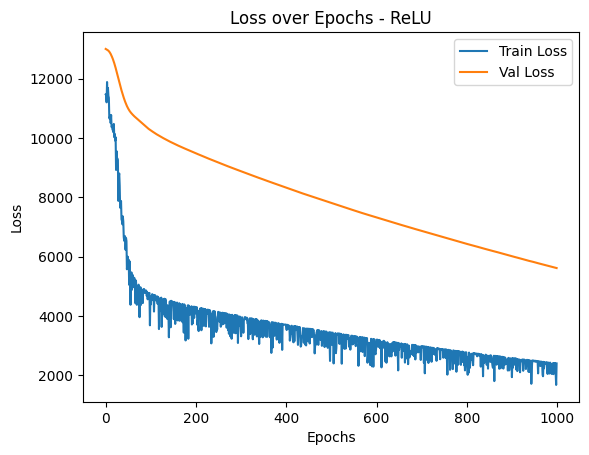

Model = LeakyReLU
Mean Squared Error: 176.6554
R^2 Score: 0.9813


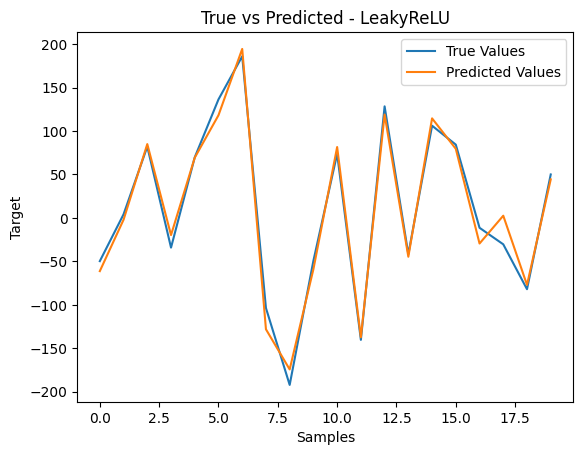

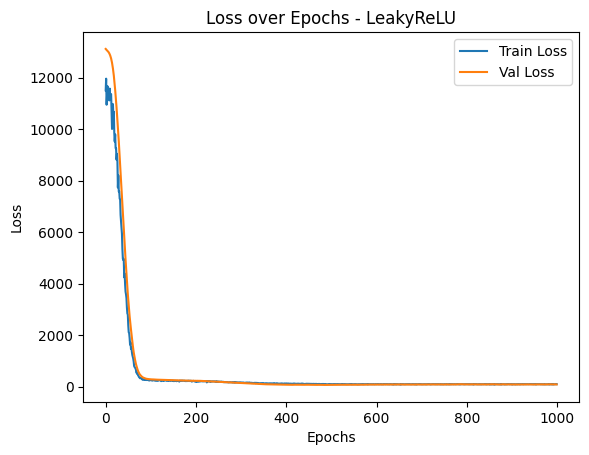

Model = Tanh
Mean Squared Error: 272.3461
R^2 Score: 0.9712


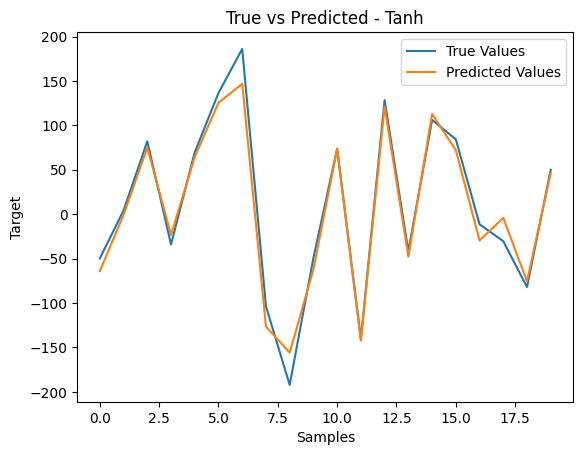

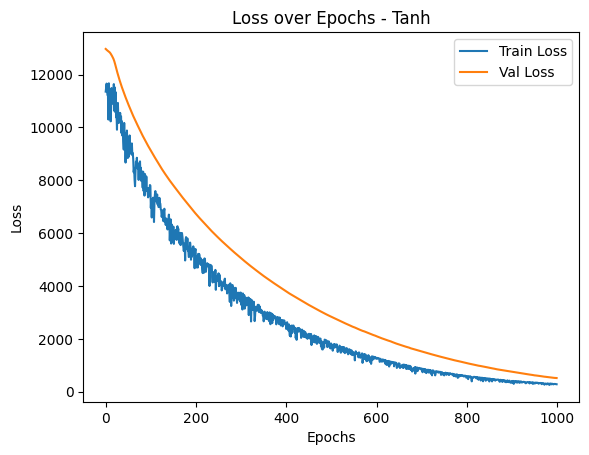

(272.34613037109375, 0.9711638689041138)

In [110]:
trainer_relu = RegressionTrainer(
    model=RegressionModel(nn.ReLU()),
    X_train=X_train, y_train=y_train,
    X_val=X_validation, y_val=y_validation,
    X_test=x_test, y_test=y_test
)

trainer_relu.train()
trainer_relu.evaluate()

trainer_leaky = RegressionTrainer(
    model = RegressionModel(nn.LeakyReLU()),
    X_train=X_train, y_train=y_train,
    X_val=X_validation, y_val=y_validation,
    X_test=x_test, y_test=y_test
)

trainer_leaky.train()
trainer_leaky.evaluate()

trainer_tanh = RegressionTrainer(
    model= RegressionModel(nn.Tanh()),
    X_train=X_train, y_train=y_train,
    X_val=X_validation, y_val=y_validation,
    X_test=x_test, y_test=y_test
)

trainer_tanh.train()
trainer_tanh.evaluate()